In [12]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

<b>TODO LIST:</b>
1. Parse audit analytics data for year and month of date of disclosure (possibly include date of breach) - Might have to select a couple of firms that we want to analyze?
    * Use year, month, and ticker to find stock price of company for that month (in WorldScope database)
    * Find stock price 1 to 12 months from that date (WorldScope). Calculate gain/loss in stock price from original. Potentially even take stock price the month before the breach?
2. Perform statistical tests + data visualization/analysis. Some examples:
    * Regression on multiple variables to predict stock price gain/loss over x months 
    * Scatter plot over time (ex: 2000-2021) of stock price gains/losses
    * Scatter plot over time after date of disclosure/breach of stock price gains/losses
    * Use Regression to see if type of breach matters for stock price
    * Regression to predict records lost?
    * Create decision tree to see type of breach

<b>Problems to maybe deal with:</b> <br>
What to do with 0 total records? - drop or use some averaging technique?
Do we combine audit analytics dataset with another one (PRC? Gordon said the PRC data is more erroneous than audit analytics, audit analytics more trusted) - make sure no repeats

<b>Resources for WRDS:</b> <br>
WorldScope (I think this is what we want): 
    https://wrds-web.wharton.upenn.edu/wrds//ds/tfn/ws/stock/index.cfm#variablesTab
    https://wrds-web.wharton.upenn.edu/wrds//ds/compd/secm/index.cfm
* Use: 5001 -- Market Price - Year End, stuff like 5015 -- End Market Price - January, 5601 -- ticker, 6038 -- IBES ticker

CRSP also works but I think WorldScope is better.
https://wrds-web.wharton.upenn.edu/wrds//ds/crsp/stock_a/msf.cfm
https://wrds-web.wharton.upenn.edu/wrds/tools/variable.cfm?library_id=20&file_id=123976


<b>There already seems to be a nice data reader for this! https://www.youtube.com/watch?v=57qAxRV577c USe this instead maybe?, stop using other stuff</b><br>

In [2]:
db = wrds.Connection()

Enter your WRDS username [gabri]:gnaval
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [4]:
# PRC Dataset 
PRC_df = pd.read_csv("../data/prc.csv" )

# Data Cleaning
PRC_df.drop(PRC_df.columns[[13,14,15]], axis=1, inplace = True)
PRC_df = PRC_df[PRC_df['Total Records'].notna()]

def records_to_int(record_str):
    return int(str(record_str).replace(",", ""))

PRC_df['Total Records'] = PRC_df['Total Records'].apply(records_to_int)

# Drop rows with 0 total records (Maybe toggle this off we want to fill in data)
PRC_df = PRC_df[PRC_df['Total Records'] != 0]

# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')
aa_ddos_df = pd.read_excel(xls, 'DDoS')

# Get rid of rows with no tickers (these might be non-publicly traded)
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)

# Ticker - Don't think we need this 
ticker_df = pd.read_csv("../data/ticker.csv" )

In [9]:
today = datetime.datetime.today().date()

def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price y months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    # Don't know if i should include this, check stock day before breach to control for large stock dip when breach is disclosed
    start -= datetime.timedelta(days=1) 
    #print(row['Ticker'])
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        #display(df)
        lst = []
        for month in range(0, num_months + 1):
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            if today <= date.date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)

In [ ]:
lst = []
months_after = 6 #Toggle this value

In [76]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
    print("%s: %s" %(index, row['Ticker']))
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

0: HUM
1: HLF
2: UCTT
3: KR
4: CTAS
5: BKEP
6: SJI
7: GSAT
8: WRK
9: CVNA
10: INDB
11: FWRD
12: TSLA
13: INTC
14: PRTS
15: USM
16: JNJ
17: WOOF
18: NWLI
19: TD
20: WMT
21: INTC
22: CLAR
23: BNTX
24: PFE
25: UPS
26: NSC
27: SFT
28: UI
29: MIME
30: VBTX
31: ACB
32: MATX
33: TMUS
34: WHR
35: CFX
36: VMW
37: NVDA
38: INTC
39: CSCO
40: MSFT
41: MD
42: CLH
43: SWI
44: SPOT
45: FEYE
46: IIVI
47: BRK.A
Error at BRK.A
KeyError('Date')
48: MTX
49: BDC
50: CAJ
51: MANU
52: SPLP
53: VIAC
54: SEAC
55: FWRD
56: SEGR
Error at SEGR
RemoteDataError('No data fetched for symbol SEGR using YahooDailyReader')
57: GEO
58: SITE
59: HD
60: UCTT
61: RDY
62: BRID
63: PFE
64: TMX
65: TMUS
66: DXPE
67: UHS
68: SBGI
69: UNM
70: UHS
71: VOXX
72: CLUBQ
73: TYL
74: RDNT
75: VCNX
76: EQIX
77: FLNT
78: WMG
79: AMPH
80: RCM
81: MAR
82: CCL
83: BF.B
Error at BF.B
KeyError('Date')
84: SRCL
85: INTC
86: CAJ
87: DVAX
88: GRMN
89: BLKB
90: TWTR
91: FORM
92: SPLP
93: TWTR
94: ULH
95: MXL
96: HMC
97: CNDT
98: CZZ
Error at CZZ


In [79]:
# Merge stock price after breach with original dataframe
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records_df = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')
display(stock_price_aa_records_df)

,Company name,Related party,Target relationship to Parent,CIK,Ticker,Market,IRS Number,Parent CIK,Parent Name,Bus Street 1,...,Lead Defendant Representation,Lead Plaintiff Representation,Litigation Settlement,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD)
0,HUMANA INC,HUMANA INC,Parent,49071,HUM,NYSE,61-0647538,NaN,NaN,500 W MAIN ST,...,NaN,NaN,NaN,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN
1,HERBALIFE NUTRITION LTD.,Herbalife Nutrition,Parent,1180262,HLF,NYSE,98-0377871,NaN,NaN,P.O. BOX 309GT,...,NaN,NaN,NaN,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN
2,"Ultra Clean Holdings, Inc.","Ultra Clean Holdings, Inc.",Parent,1275014,UCTT,Nasdaq Global Market,61-1430858,NaN,NaN,150 INDEPENDENCE DRIVE,...,NaN,NaN,NaN,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN
3,KROGER CO,Kroger Pharmacy,Parent,56873,KR,NYSE,31-0345740,NaN,NaN,1014 VINE ST,...,NaN,NaN,NaN,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN
4,CINTAS CORP,Cintas Corporation,Parent,723254,CTAS,Nasdaq Global Market,31-1188630,NaN,NaN,6800 CINTAS BLVD,...,NaN,NaN,NaN,345.100006,351.600006,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,Costco Photo Center; PNI Digital Media,Third-party,909832,COST,Nasdaq Global Market,91-1223280,NaN,NaN,999 LAKE DRIVE,...,NaN,NaN,NaN,142.649994,158.149994,163.449997,161.229996,153.690002,150.059998,152.229996
733,RITE AID CORP,Rite Aid Pharmacy; PNI Digital Media,Third-party,84129,RAD,NYSE,23-1614034,NaN,NaN,30 HUNTER LANE,...,NaN,NaN,NaN,146.600006,124.400002,154.199997,157.399994,154.199997,159.000000,159.800003
734,CVS HEALTH Corp,CVSphoto.com; PNI Digital Media,Third-party,64803,CVS,NYSE,05-0494040,NaN,NaN,ONE CVS DR.,...,NaN,NaN,NaN,100.800003,102.000000,97.839996,94.739998,94.919998,93.110001,99.339996
735,WEYERHAEUSER CO,Premera Blue Cross,Third-party,106535,WY,NYSE,91-0470860,NaN,NaN,220 OCCIDENTAL AVENUE SOUTH,...,NaN,NaN,NaN,33.680000,32.150002,32.340000,32.959999,30.959999,31.080000,28.450001


In [80]:
# Store new dataframe as csv for easy load-in/testing
stock_price_aa_records_df.to_csv("../data/stock_price_aa_records.csv")

In [10]:
# Load in dataframe
stock_price_aa_records = pd.read_csv("../data/stock_price_aa_records.csv")

In [7]:
display(stock_price_aa_records)

,Unnamed: 0,Company name,Related party,Target relationship to Parent,CIK,Ticker,Market,IRS Number,Parent CIK,Parent Name,...,Lead Defendant Representation,Lead Plaintiff Representation,Litigation Settlement,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD)
0,0,HUMANA INC,HUMANA INC,Parent,49071,HUM,NYSE,61-0647538,NaN,NaN,...,NaN,NaN,NaN,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN
1,1,HERBALIFE NUTRITION LTD.,Herbalife Nutrition,Parent,1180262,HLF,NYSE,98-0377871,NaN,NaN,...,NaN,NaN,NaN,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN
2,2,"Ultra Clean Holdings, Inc.","Ultra Clean Holdings, Inc.",Parent,1275014,UCTT,Nasdaq Global Market,61-1430858,NaN,NaN,...,NaN,NaN,NaN,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN
3,3,KROGER CO,Kroger Pharmacy,Parent,56873,KR,NYSE,31-0345740,NaN,NaN,...,NaN,NaN,NaN,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN
4,4,CINTAS CORP,Cintas Corporation,Parent,723254,CTAS,Nasdaq Global Market,31-1188630,NaN,NaN,...,NaN,NaN,NaN,345.100006,351.600006,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,732,COSTCO WHOLESALE CORP /NEW,Costco Photo Center; PNI Digital Media,Third-party,909832,COST,Nasdaq Global Market,91-1223280,NaN,NaN,...,NaN,NaN,NaN,142.649994,158.149994,163.449997,161.229996,153.690002,150.059998,152.229996
733,733,RITE AID CORP,Rite Aid Pharmacy; PNI Digital Media,Third-party,84129,RAD,NYSE,23-1614034,NaN,NaN,...,NaN,NaN,NaN,146.600006,124.400002,154.199997,157.399994,154.199997,159.000000,159.800003
734,734,CVS HEALTH Corp,CVSphoto.com; PNI Digital Media,Third-party,64803,CVS,NYSE,05-0494040,NaN,NaN,...,NaN,NaN,NaN,100.800003,102.000000,97.839996,94.739998,94.919998,93.110001,99.339996
735,735,WEYERHAEUSER CO,Premera Blue Cross,Third-party,106535,WY,NYSE,91-0470860,NaN,NaN,...,NaN,NaN,NaN,33.680000,32.150002,32.340000,32.959999,30.959999,31.080000,28.450001


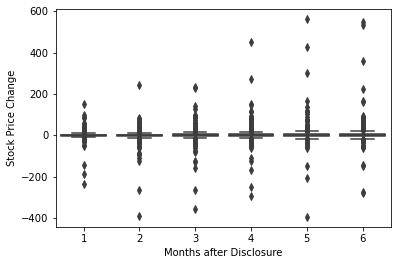

In [38]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: row[x] - row[col[0]], axis = 1)
    n += 1

boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Stock Price Change')
plt.show()

In [89]:
# USE ALPHA VANTAGE to get missing entries?
# web.DataReader("BRK.A", "av-daily", start=datetime.datetime(2017, 2, 9), end=datetime.datetime(2017, 5, 24), api_key="")

,open,high,low,close,volume
2017-02-09,244877.00,246700.0,244350.00,246000.00,458
2017-02-10,246899.80,246950.0,245490.00,246000.00,314
2017-02-13,246800.00,249270.0,246800.00,248340.05,367
2017-02-14,248750.00,250440.0,247810.00,250419.00,388
2017-02-15,250418.99,250990.0,249240.00,250990.00,784
...,...,...,...,...,...
2017-05-18,243000.00,244450.0,242180.00,242510.00,288
2017-05-19,243355.00,246220.0,242840.54,244910.00,254
2017-05-22,247499.90,248270.0,246200.50,247820.00,482
2017-05-23,248100.00,248690.0,247390.00,248121.00,327
